In [1]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer
from sklearn import preprocessing
import statsmodels.api as sm
from scipy.stats import f
from scipy.stats import multivariate_normal
from statsmodels.stats.diagnostic import het_breuschpagan
import scipy.cluster.hierarchy as sch
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
from scipy.fft import fft
%matplotlib inline

### Data processing

Extract data from Johns Hopkins (aggregated data from WHO daily reports)

In [2]:
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
data = pd.read_csv(url)

Select only territories inside the US (drop Puerto Rico and etc.) and delete unnesessary fields

In [3]:
data = data[data['iso2'] == 'US']

In [4]:
del data['UID']
del data['iso2']
del data['iso3']
del data['code3']
del data['FIPS']
del data['Country_Region']
del data['Lat']
del data['Long_']

In [5]:
data.head()

,Admin2,Province_State,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20
5,Autauga,Alabama,"Autauga, Alabama, US",0,0,0,0,0,0,0,...,265,272,282,295,312,323,331,357,364,367
6,Baldwin,Alabama,"Baldwin, Alabama, US",0,0,0,0,0,0,0,...,313,320,325,331,343,353,361,364,368,374
7,Barbour,Alabama,"Barbour, Alabama, US",0,0,0,0,0,0,0,...,193,197,199,208,214,221,226,234,237,244
8,Bibb,Alabama,"Bibb, Alabama, US",0,0,0,0,0,0,0,...,77,79,85,89,93,97,100,104,108,113
9,Blount,Alabama,"Blount, Alabama, US",0,0,0,0,0,0,0,...,72,73,75,79,87,95,102,110,114,119


Select only counties with >0 cases

In [6]:
data = data[data[data.columns[-1]] != 0]

Create new dataframe with delta cases per date. Join with county population table.

In [7]:
data_deltas = pd.DataFrame(data[['Admin2', 'Province_State', 'Combined_Key']])
for i in range(4,len(data.columns)):     #check index with df form
  data_deltas[data.columns[i]] = data[data.columns[i]] - data[data.columns[i-1]]

In [8]:
data_deltas.rename(columns={'Admin2':'County'}, inplace=True)

In [9]:
data_deltas.head()

,County,Province_State,Combined_Key,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20
5,Autauga,Alabama,"Autauga, Alabama, US",0,0,0,0,0,0,0,...,6,7,10,13,17,11,8,26,7,3
6,Baldwin,Alabama,"Baldwin, Alabama, US",0,0,0,0,0,0,0,...,9,7,5,6,12,10,8,3,4,6
7,Barbour,Alabama,"Barbour, Alabama, US",0,0,0,0,0,0,0,...,3,4,2,9,6,7,5,8,3,7
8,Bibb,Alabama,"Bibb, Alabama, US",0,0,0,0,0,0,0,...,0,2,6,4,4,4,3,4,4,5
9,Blount,Alabama,"Blount, Alabama, US",0,0,0,0,0,0,0,...,2,1,2,4,8,8,7,8,4,5


### Population

Source: US Census

In [10]:
df_pop = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/population_counties.csv', sep=';', decimal=',')

In [11]:
data_pop = data_deltas.join(df_pop.set_index('County'), on='County', how='left')

In [12]:
del data_pop['Combined_Key']

In [13]:
data_pop.head()

,County,Province_State,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,Population
5,Autauga,Alabama,0,0,0,0,0,0,0,0,...,7,10,13,17,11,8,26,7,3,NaN
6,Baldwin,Alabama,0,0,0,0,0,0,0,0,...,7,5,6,12,10,8,3,4,6,NaN
7,Barbour,Alabama,0,0,0,0,0,0,0,0,...,4,2,9,6,7,5,8,3,7,NaN
8,Bibb,Alabama,0,0,0,0,0,0,0,0,...,2,6,4,4,4,3,4,4,5,NaN
9,Blount,Alabama,0,0,0,0,0,0,0,0,...,1,2,4,8,8,7,8,4,5,NaN


In [14]:
data_pop = data_pop[data_pop['Population'].isnull() == False]

Create a dataframe containing daily new cases per person (deltas divided by population).

In [15]:
data_deltas_rel = pd.DataFrame(data_pop['County'])
for i in range(data_pop.shape[1] - 2):
    data_deltas_rel[data_pop.columns[i]] = data_pop[data_pop.columns[i]]/data_pop['Population']

Create a list containing trimmed sequences of relative deltas. They will have different lengths and can't be stored in a pd.DataFrame or an np.array. Store only counties with more then 50% values not 0.

In [16]:
lst = []
for i in range(data_deltas_rel.shape[0]):
    county_trimmed = [data_deltas_rel.iloc[i,0]] + list(np.trim_zeros(data_deltas_rel.iloc[i,1:]))
    if county_trimmed.count(0.0)/len(county_trimmed) <= 0.5:
        lst.append(county_trimmed)

### Population Density

Source: US Census (https://www.census.gov/library/publications/2011/compendia/usa-counties-2011.html#LND)

In [17]:
df_pop = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/population_counties.csv', sep=';', decimal=',')

In [18]:
county_area = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/counties_area.csv', sep=";")

Source: USPS (https://pe.usps.com/text/pub28/28apb.htm). A dictionary mapping for 2-letter state names

In [19]:
state_2l = pd.read_csv('https://raw.githubusercontent.com/svetryabova/NMHUcovid19/master/data/states_2l.csv', sep=';')
st_2l_d = dict(zip(state_2l.iloc[:,0], state_2l.iloc[:,1]))

Transform combined county names to format with 2-letter states

In [20]:
tmp = np.transpose([i.split(', ') for i in df_pop['County']])
df_pop['County'] = tmp[0]
df_pop['State'] = [st_2l_d[i] for i in tmp[1]]

In [21]:
df_pop['County'] = df_pop['County'] + ', ' + df_pop['State']

Join tables with population and area data to calculate population density

In [22]:
county_area.rename(columns={'Areaname':'County'}, inplace=True)

In [23]:
df_pop = df_pop.join(county_area.set_index('County'), on='County', how='left')

In [24]:
df_pop['Population Density'] = df_pop['Population']/df_pop['LND110210D']
del df_pop ['Population']
del df_pop['LND110210D']
del df_pop['STCOU']
del df_pop['State']

Transform data_deltas to the same key format as in population density table

In [25]:
data_deltas = data_deltas[data_deltas['Province_State'].isin(st_2l_d.keys())]
data_deltas['State'] = [st_2l_d[i] for i in data_deltas['Province_State']]
del data_deltas['Province_State']
data_deltas['County'] = data_deltas['County'] + ', ' + data_deltas['State']
del data_deltas['Combined_Key']
del data_deltas['State']

Join data_deltas table with population density one to create a time series of deltas divided by population density

In [26]:
data_dens = data_deltas.join(df_pop.set_index('County'), on='County', how='inner')

In [27]:
data_deltas_rel = pd.DataFrame(data_dens['County'])
for i in range(1, data_dens.shape[1] - 1):
    data_deltas_rel[data_dens.columns[i]] = data_dens[data_dens.columns[i]]/data_dens['Population Density']

Replace negative values with their absolutes, assuming there was a mistake in collecting/processing

In [28]:
data_deltas_rel.iloc[:,1:] = data_deltas_rel.iloc[:,1:].abs()

In [29]:
data_deltas_rel.head()

,County,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20
5,"Autauga, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.063839,0.074479,0.106399,0.138319,0.180878,0.117039,0.085119,0.276637,0.074479,0.031920
6,"Baldwin, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.064094,0.049851,0.035608,0.042730,0.085459,0.071216,0.056973,0.021365,0.028486,0.042730
7,"Barbour, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.107536,0.143382,0.071691,0.322609,0.215073,0.250918,0.179227,0.286763,0.107536,0.250918
8,"Bibb, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.055602,0.166807,0.111205,0.111205,0.111205,0.083404,0.111205,0.111205,0.139006
9,"Blount, AL",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022301,0.011150,0.022301,0.044601,0.089203,0.089203,0.078052,0.089203,0.044601,0.055752


Create a list of time series for linear regressions:
1) trim zeros on the left
2) find the sequence of max length
3) pad all the other sequences with zeros from the left to the length of maximal (in order to build common model for several series)

In [30]:
lst = []
names = []
for i in range(data_deltas_rel.shape[0]):
    county_trimmed = list(np.trim_zeros(data_deltas_rel.iloc[i,1:], 'f'))
    if county_trimmed.count(0.0)/len(county_trimmed) <= 0.5:
        names.append(data_deltas_rel.iloc[i,0])
        lst.append(county_trimmed)
l = max([len(i) for i in lst])
for i in range(len(lst)):
    lst[i] = [names[i]] + list(np.pad(lst[i], (l - len(lst[i]), 0)))

### Linear regressions

Build linear regression models for each county. Take maximal polynomial degree = 4. Include features stepwise, using partial F-test as significance criterion.

In [31]:
norm_lst = []
lr_lst = []
county_lst = []
x_lst = []
ypr_lst = []
ts_size = len(lst[0]) - 1
x_range = np.array(range(ts_size))
x_range2 = np.array(range(ts_size))**2
x_range3 = np.array(range(ts_size))**3
x_range4 = np.array(range(ts_size))**4
x = [x_range, x_range2, x_range3, x_range4]
x = sm.add_constant(np.transpose(x))
for i in range(len(lst)):
    y = np.array(lst[i])[1:].astype('float32')
    y_mean = np.mean(y)
    jb_test = sm.stats.stattools.jarque_bera(y)   #check normality of data
    if jb_test[1] < 0.1:
        norm_lst.append(lst[i])
        x1 = x[:, :1]
        lr_fin = sm.OLS(y, x1).fit()
        for j in range(2, 5):
            lr0 = lr_fin
            x0 = x1
            y_pr0 = lr0.predict(x0)
            ssr0 = sum((y_pr0 - y_mean)**2)
            x1 = x[:, :j+1]
            lr1 = sm.OLS(y, x1).fit()
            y_pr1 = lr1.predict(x1)
            ssr1 = sum((y_pr1 - y_mean)**2)
            ssr_new = ssr1 - ssr0
            mse1 = sum((y - y_pr1)**2)/(len(y) + j - 2)
            if ssr_new/mse1 <= f.ppf(0.05, 1, (len(y) + j - 2)):
                y_pr = y_pr0
                x_fin = x0
                break
            y_pr = y_pr1
            x_fin = x1
            lr_fin = lr1          #check residuals for normality and abscence of heteroskedasticity
        if sm.stats.stattools.jarque_bera(lr_fin.resid)[1] < 0.1 and het_breuschpagan(lr_fin.resid, x[:, :len(lr_fin.params)])[-1] < 0.1:
            county_lst.append(lst[i][0])       #save model if it passes the tests
            lr_lst.append(lr_fin)
            ypr_lst.append(y_pr)

c:\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
c:\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
c:\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [32]:
ypr_lst = np.array(ypr_lst)
rows, cols = ypr_lst.shape
for i in range(rows):
    ypr_lst[i, :] /= np.max(ypr_lst[i, :])

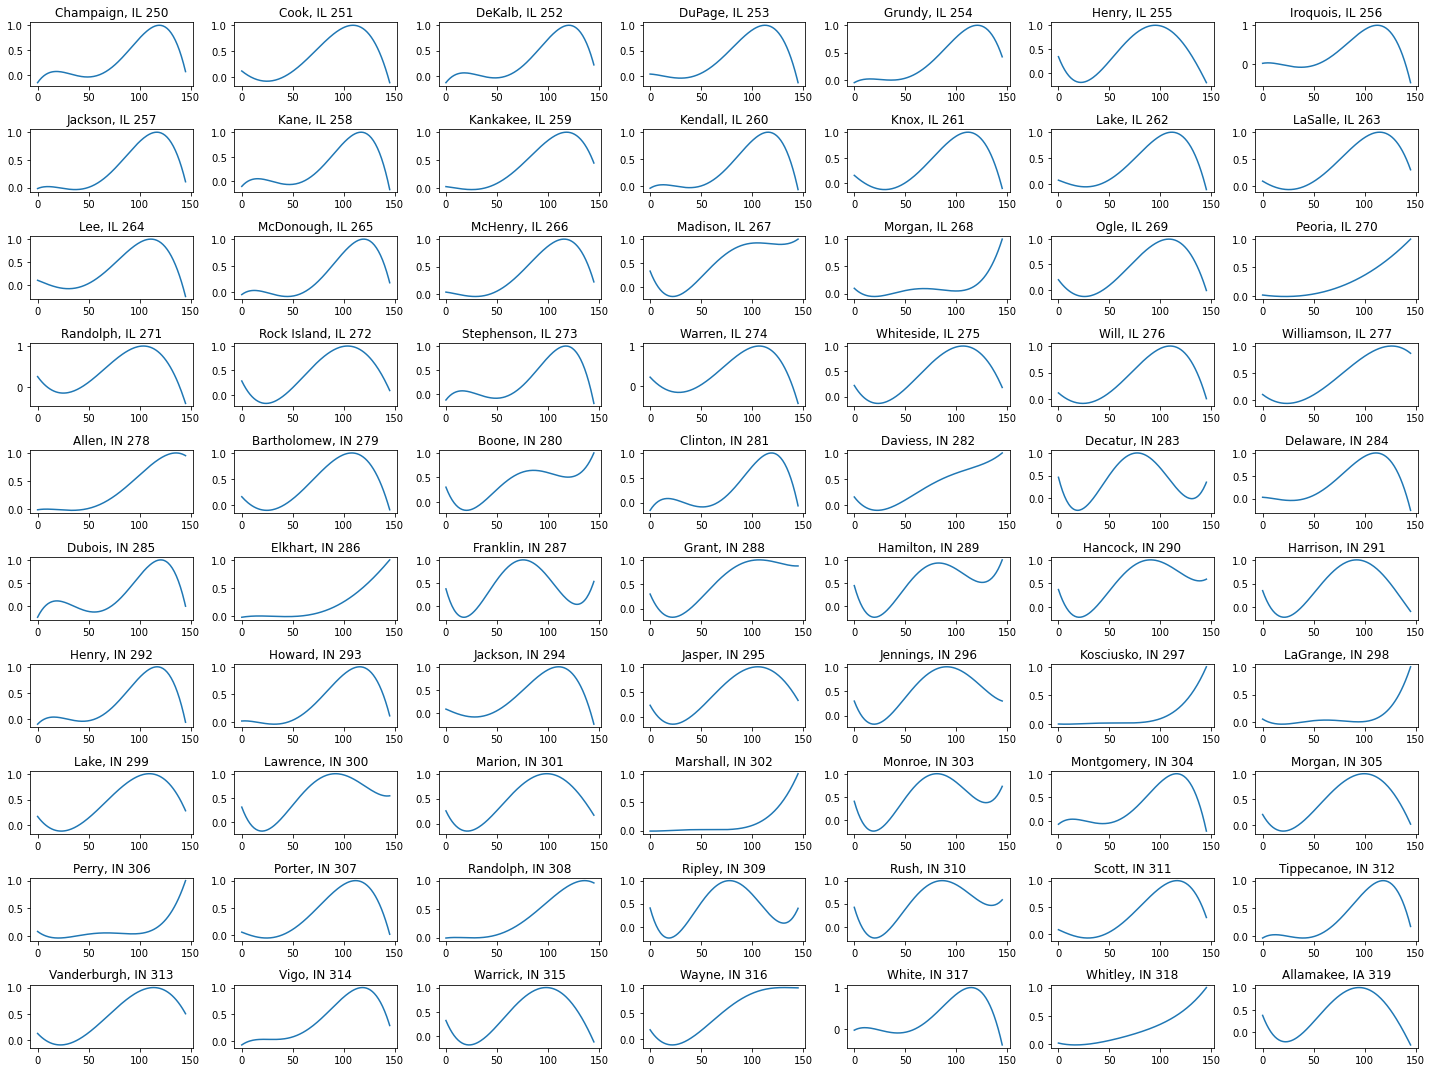

In [33]:
fig, axs = plt.subplots(10, 7, figsize=(20,15))
offset = 250
for i in range(70):
    axs[i//7, np.mod(i,7)].plot(ypr_lst[i + offset])
    axs[i//7, np.mod(i,7)].set_title(county_lst[i + offset] + ' ' + str(i + offset))
fig.tight_layout()

Work only with several specified counties:  
San Juan NM - 573  
Santa Fe NM - 574  
New York - 588  
Cook IL - 251  
Whitley IN - 318

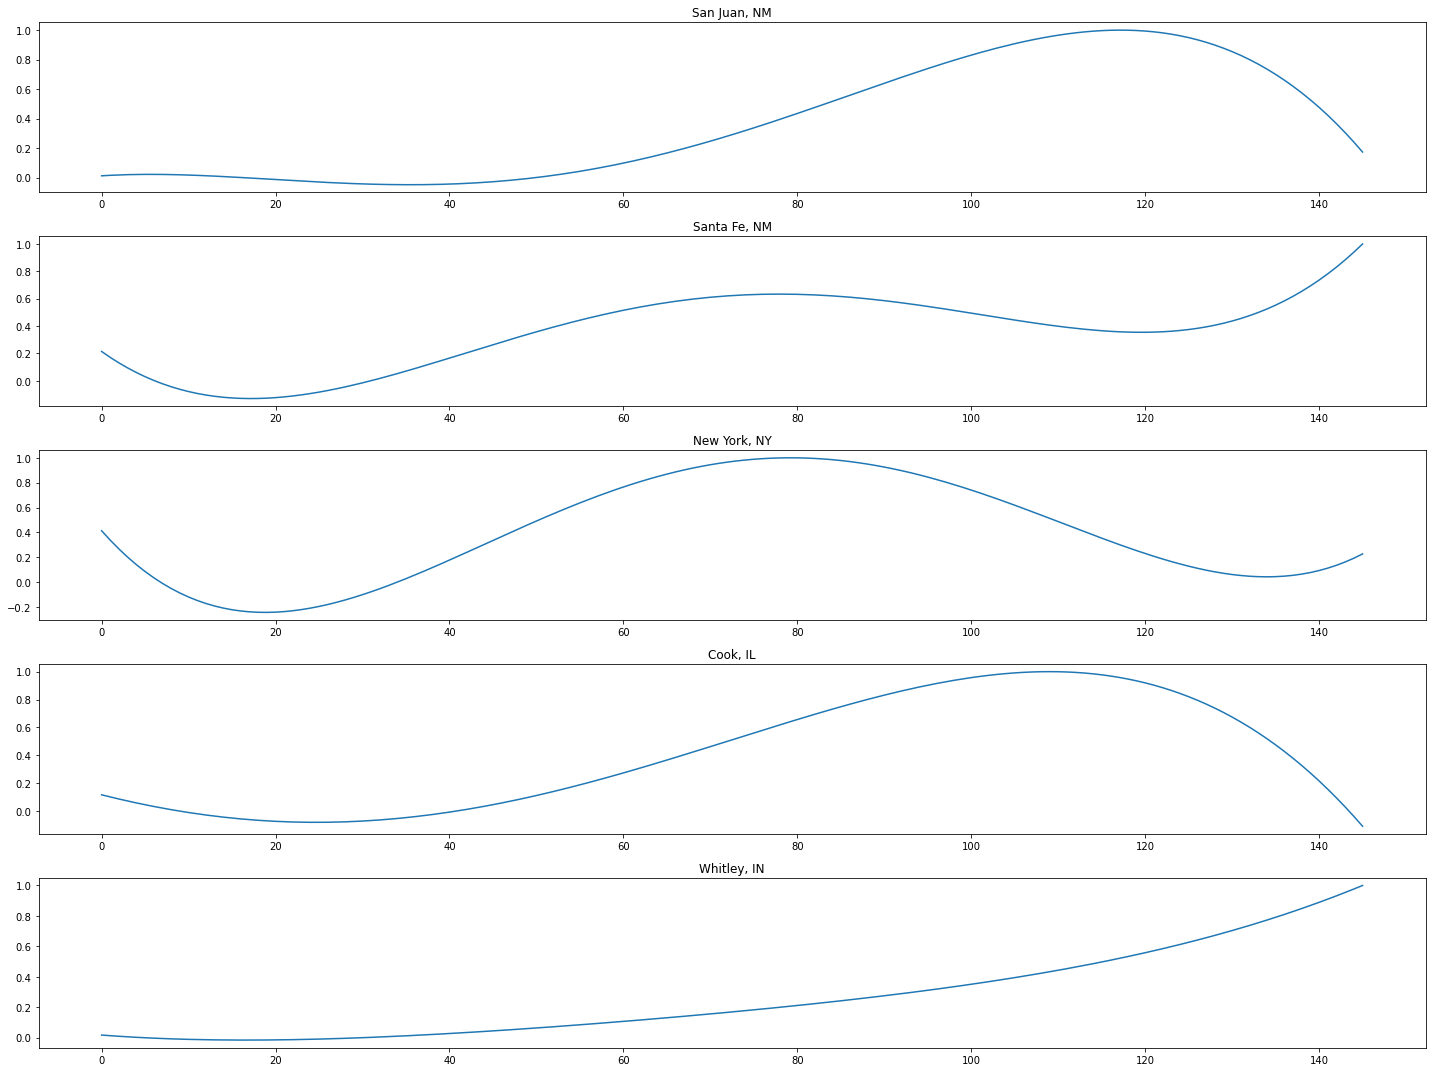

In [34]:
indices = (573, 574, 588, 251, 318)
fig, axs = plt.subplots(5, 1, figsize=(20, 15))
for i in range(len(indices)):
    idx = indices[i]
    axs[i].plot(ypr_lst[idx])
    axs[i].set_title(county_lst[idx])
fig.tight_layout()

### Amplitude spectrum

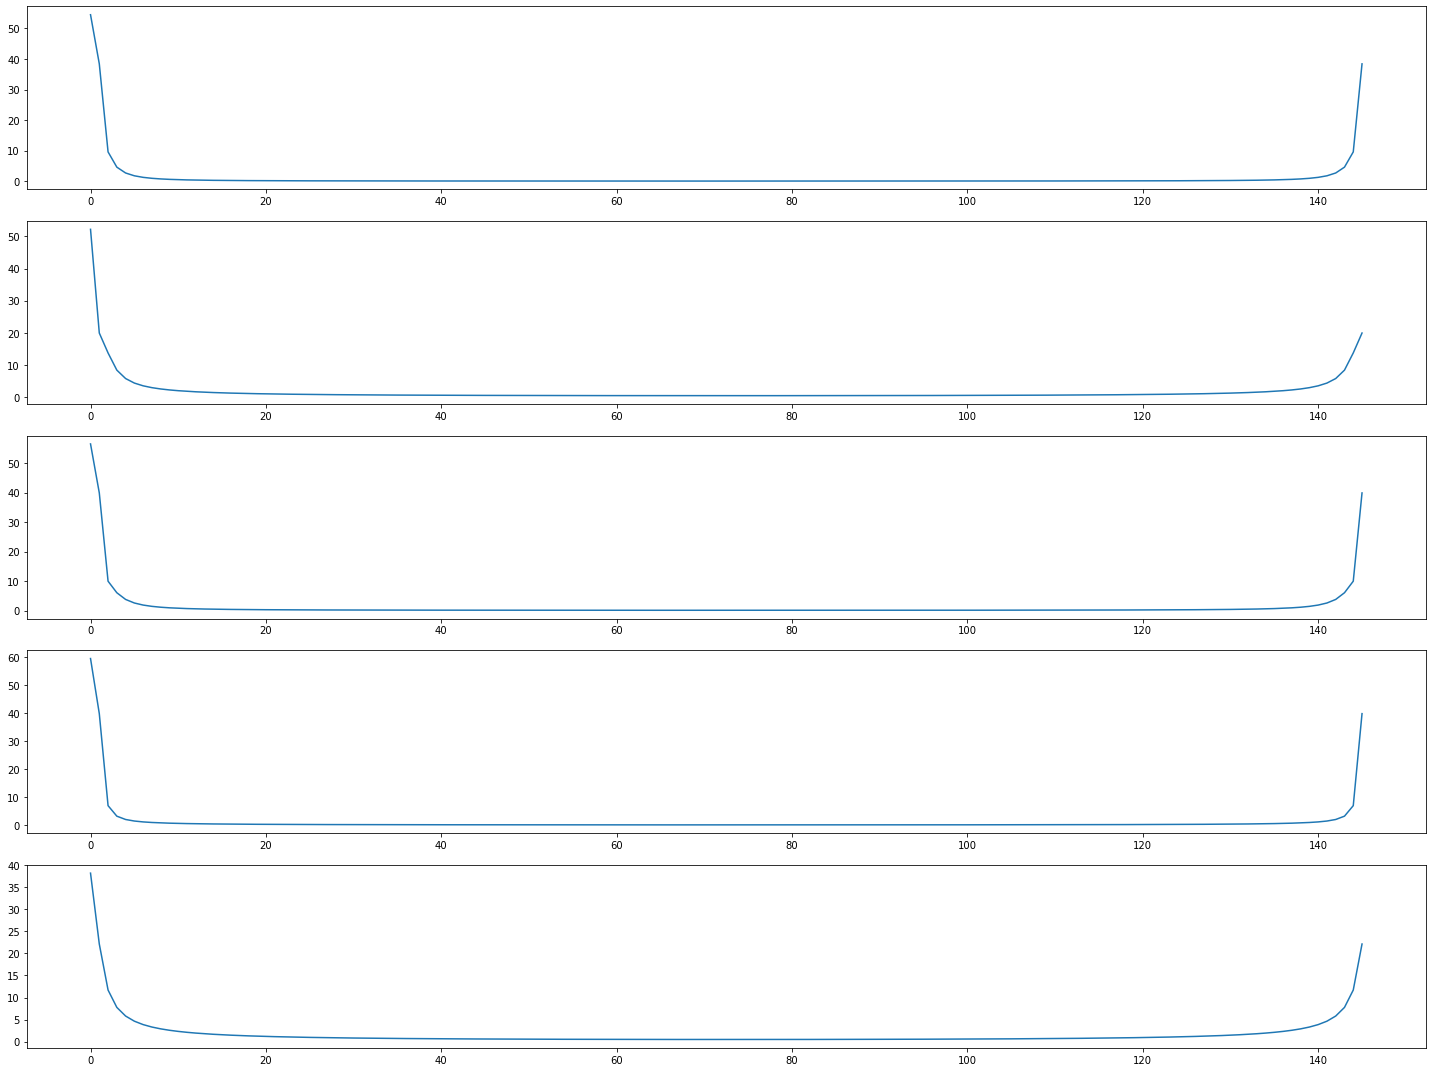

In [35]:
#fft
ffts = []
for i in range(len(indices)):
    idx = indices[i]
    ffts.append(np.abs(fft(ypr_lst[idx])))
fig, axs = plt.subplots(5, 1, figsize=(20, 15))
for i in range(len(ffts)):
    axs[i].plot(ffts[i])
fig.tight_layout()

### Phase spectrum

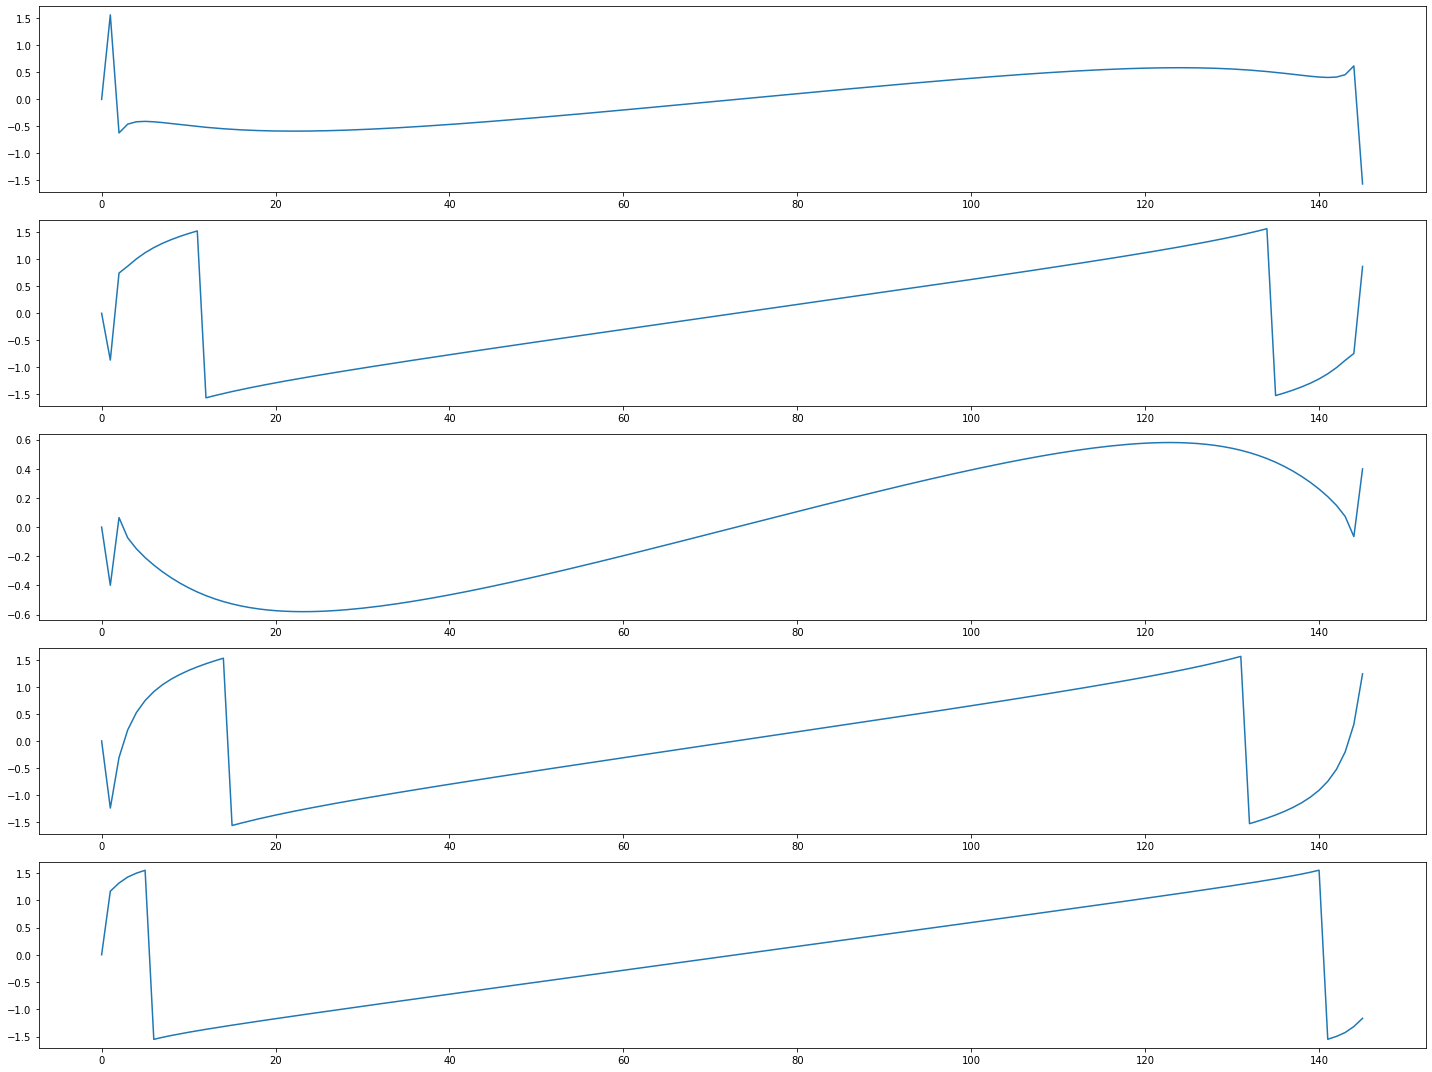

In [38]:
# phase spectrum
phases = []
for i in range(len(indices)):
    idx = indices[i]
    s = fft(ypr_lst[idx])
    phases.append(np.arctan(np.divide(s.imag, s.real)))
fig, axs = plt.subplots(5, 1, figsize=(20, 15))
for i in range(len(ffts)):
    axs[i].plot(phases[i])
fig.tight_layout()

### Hierarchy

In [0]:
sc0 = preprocessing.MinMaxScaler()
sc1 = preprocessing.StandardScaler()
normalized_regr = pd.DataFrame(sc0.fit_transform(params))
normalized_regr['County'] = county_lst
clust_test0 = normalized_regr.copy()
stand_regr = pd.DataFrame(sc1.fit_transform(params))
stand_regr['County'] = county_lst
clust_test1 = stand_regr.copy()

In [0]:
dendrogram0 = sch.dendrogram(sch.linkage(normalized_regr.iloc[:,:-1], method='ward'))
plt.title('Dendrogram0')
plt.ylabel('Euclidean distance')
plt.show()
dendrogram1 = sch.dendrogram(sch.linkage(stand_regr.iloc[:,:-1], method='ward'))
plt.title('Dendrogram1')
plt.ylabel('Euclidean distance')
plt.show()

In [0]:
clustering = cluster.AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')

In [0]:
clust_test1['Cluster'] = clustering.fit_predict(clust_test1.iloc[:,:-1])

In [0]:
clust_test1[clust_test1['Cluster'] == 2]

### Regression Mixtures

In [88]:
len(county_lst)

957

In [89]:
p = max([len(reg.params) for reg in lr_lst]) - 1
params = pd.DataFrame([np.pad(reg.params, (0, p - len(reg.params) + 1)) for reg in lr_lst])

IndexError: index 60 is out of bounds for axis 0 with size 60

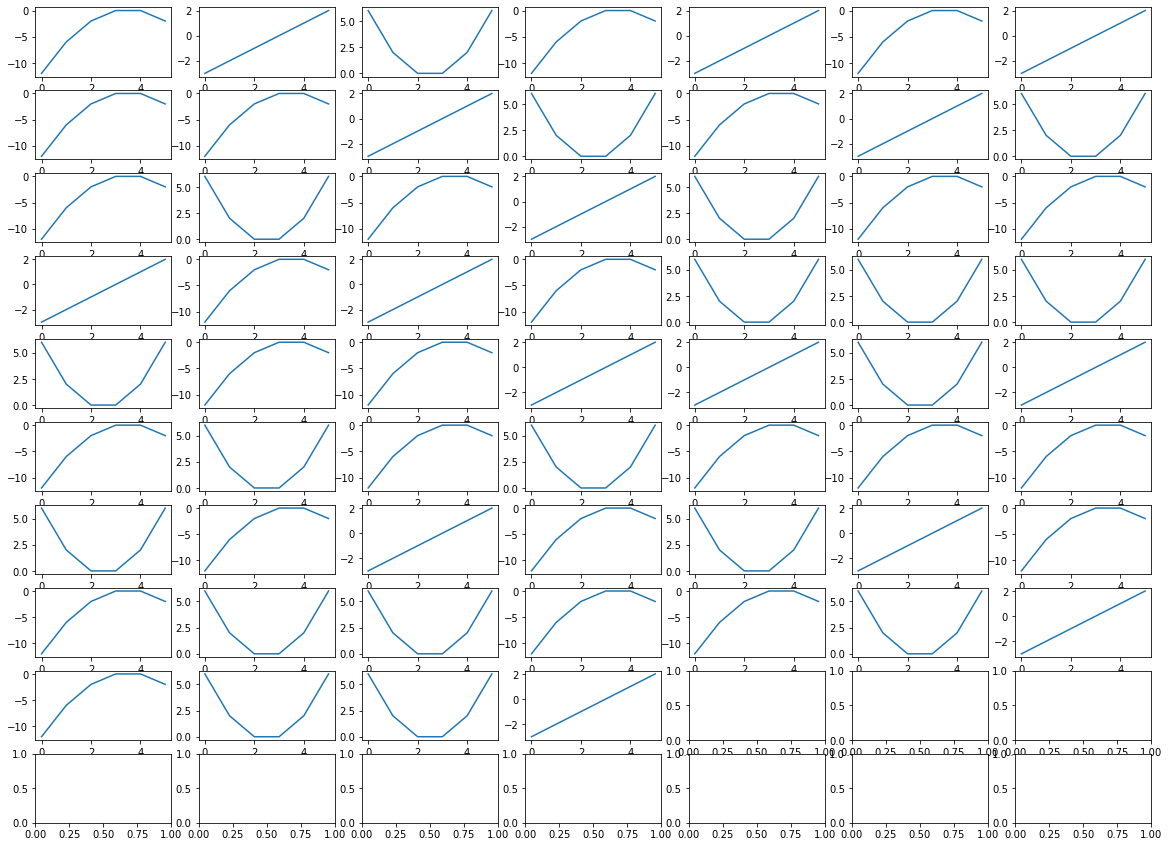

In [314]:
fig, axs = plt.subplots(10, 7, figsize=(20,15))
for i in range(70):
    axs[i//7, np.mod(i,7)].plot(np.dot(test_params, np.transpose(x))[idxs3][i])

In [227]:
from random import shuffle
test_p = 3
test_params = [[0,1,0,0]]*30 + [[0,1,1,0]]*30 + [[0,1,-1,0]]*30
shuffle(test_params)

In [172]:
x_range = np.array(range(-3,3))
x_range2 = np.array(range(-3,3))**2
x_range3 = np.array(range(-3,3))**3
x = [x_range, x_range2, x_range3]
x = sm.add_constant(np.transpose(x))

In [4]:
k = 3

In [174]:
test_ypr = np.dot(x, np.transpose(test_params)).T

In [105]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(params)

In [106]:
test_part = kmeans.labels_

In [325]:
class Regression_Mixtures_Model:
    def __init__(self, k, n, p, ts_size):
        self.k = k
        self.n = n
        self.p = p
        self.tslen = ts_size
        self.partition = np.random.randint(0, self.k, self.n).tolist()
        self.pi = [self.partition.count(i)/self.n for i in range(self.k)]
        self.ll_old = -10000000       #think about init values
        self.ll_new = -1000000
        self.ll_stat = []

    def indicator_max(self, array):
        max_idx = max(list(zip(array, range(self.k))))
        return [0]*(max_idx[1])+[1]+[0]*(self.k-max_idx[1]-1)
    
    def init_EM(self, par, ypr_lst, x):
        self.cov_lst = []
        #self.means_lst = []
        self.par_lst = []
        #self.par_lst = np.array(par.iloc[[3,8,11, 14],:])
        for i in range(self.k):
            idx = [j for j, e in enumerate(self.partition) if e == i]
            self.par_lst.append(np.array(pd.DataFrame(par).iloc[idx[0],:]))   #using mean is questionable             params are a pd dataframe
            #self.means_lst.append(np.dot(x, self.par_lst[i]))
            self.cov_lst.append(np.cov((pd.DataFrame(ypr_lst).iloc[idx, :] - np.dot(x, self.par_lst[i])).mean())*np.identity(self.tslen))   #using mean is questionable
        #self.cov_lst = [np.identity(self.tslen)]*self.k   #should be cov, not identity
        self.cov_lst = np.array([sum(self.pi[i]*np.linalg.norm(ypr_lst[j] - np.dot(x, self.par_lst[i]))**2 for j in range(self.n)) for i in range(self.k)])/self.pi
   
    def Expectation(self, ypr_lst):
        self.tau_lst = []
        self.ll_old = self.ll_new
        ll_lst = []
        #z_lst = []
        for i in range(self.n):
            tau_lst_tmp = []
            ll_lst_tmp = []
            s = 0
            for j in range(self.k):
                n_prob = self.pi[j]*multivariate_normal(np.dot(x, self.par_lst[j]), self.cov_lst[j]).pdf(ypr_lst[i])
                tau_lst_tmp.append(n_prob)
                ll_lst_tmp.append(np.log(n_prob))
                s += n_prob
            #add ll_new update here
            ll_lst.append(np.array(ll_lst_tmp))
            #z_lst.append(self.indicator_max(tau_lst_tmp))
            self.tau_lst.append(np.array(tau_lst_tmp)/s)
        ll_lst = np.array(ll_lst)
        #z_lst = np.array(z_lst)
        self.tau_lst = np.array(self.tau_lst)
        self.ll_new = sum(sum(ll_lst*self.tau_lst))
        self.ll_stat.append(self.ll_new)

    def Maximization(self, ypr_lst, x):
        self.pi = 1/self.n*sum(self.tau_lst)
        pt1 = [np.linalg.inv(sum(self.tau_lst[j][i]*np.dot(x.T, x) for j in range(self.n))) for i in range(self.k)]
        pt2 = [sum(self.tau_lst[j][i]*np.dot(x.T, ypr_lst[i]) for j in range(self.n)) for i in range(self.k)]
        self.par_lst = [np.dot(pt1[i], pt2[i]) for i in range(self.k)]
        self.cov_lst = np.array([sum(self.tau_lst[j][i]*np.linalg.norm(ypr_lst[j] - np.dot(x, self.par_lst[i]))**2 for j in range(self.n)) for i in range(self.k)])/sum(self.tau_lst)
    
    def EM(self, par, ypr_lst, x, eps=0.01):
        self.init_EM(par, ypr_lst, x)
        for i in range(7): #while self.ll_new - self.ll_old > eps:
            #break
            self.Expectation(ypr_lst)
            #print('e')
            self.Maximization(ypr_lst, x)
            #print('m')
            print(i)
        self.Expectation(ypr_lst)   #to get posterior probabilities after the last maximization step
        self.output = [self.indicator_max(self.tau_lst[i]) for i in range(self.n)]


In [333]:
rm = Regression_Mixtures_Model(k, len(params), p, len(x))

In [335]:
rm.EM(params, ypr_lst, x, eps=1000)

0
1
2
3
4


c:\miniconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log
c:\miniconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


LinAlgError: Singular matrix

In [336]:
rm.ll_stat

[-673283.3841475619,
 -227506.18483213725,
 -142546.32402215703,
 -161776.2103983951,
 -143101.36550048814,
 nan]

In [233]:
tau_lst = []
ll_lst = []
for i in range(rm.n):
    tau_lst_tmp = []
    ll_lst_tmp = []
    s = 0
    for j in range(rm.k):
        n_prob = rm.pi[j]*multivariate_normal(np.dot(x, rm.par_lst[j]), rm.cov_lst[j]).pdf(test_ypr[i])
        tau_lst_tmp.append(n_prob)
        ll_lst_tmp.append(np.log(n_prob))
        s += n_prob
    #print(s)
    tau_lst.append(tau_lst_tmp/s)
    ll_lst.append(ll_lst_tmp)
tau_lst = np.array(tau_lst)
ll_lst = np.array(ll_lst)

In [313]:
t = sum((np.array(rm.output)*np.array([[1,2,3]]*rm.n)).T)
idxs1 = [j for j, e in enumerate(t) if e == 1]
idxs2 = [j for j, e in enumerate(t) if e == 2]
idxs3 = [j for j, e in enumerate(t) if e == 3]

In [288]:
np.dot(x, test_params[i])

array([6., 2., 0., 0., 2., 6.])

In [286]:
np.dot(test_params, np.transpose(x))[idxs3]

array([[-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.],
       [  6.,   2.,   0.,   0.,   2.,   6.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.],
       [  6.,   2.,   0.,   0.,   2.,   6.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.],
       [  6.,   2.,   0.,   0.,   2.,   6.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [  6.,   2.,   0.,   0.,   2.,   6.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.],
       [  6.,   2.,   0.,   0.,   2.,   6.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [-12.,  -6.,  -2.,   0.,   0.,  -2.],
       [ -3.,  -2.,  -1.,   0.,   1.,   2.],
       [-1

In [234]:
rm.pi

[0.25555555555555554, 0.3333333333333333, 0.4111111111111111]

In [235]:
pi1 = 1/rm.n*sum(tau_lst)
pi1

array([0.41124643, 0.43347339, 0.15528018])

In [236]:
t1 = [np.linalg.inv(sum(tau_lst.T[i][j]*np.dot(x.T, x) for j in range(rm.n))) for i in range(rm.k)]

In [237]:
t2 = [sum(tau_lst.T[i][j]*np.dot(x.T, test_ypr[i]) for j in range(rm.n)) for i in range(rm.k)]

In [238]:
t2

[array([ -407.13396699,  3960.30313344, -5736.88771666, 27055.90271536]),
 array([ -429.13865718,  4174.34875616, -6046.95380566, 28518.21439958]),
 array([  223.60345576,  -111.80172788,  1229.81900668, -1788.82764609])]

In [239]:
pl = [np.dot(t1[i], t2[i]) for i in range(k)]

In [240]:
cov = np.array([sum(tau_lst.T[i][j]*np.linalg.norm(test_ypr[j] - np.dot(x, pl[i]))**2 for j in range(rm.n)) for i in range(rm.k)])/sum(tau_lst)

In [241]:
tau_lst1 = []
ll_lst1 = []
for i in range(rm.n):
    tau_lst_tmp = []
    ll_lst_tmp = []
    s = 0
    for j in range(rm.k):
        n_prob = pi1[j]*multivariate_normal(np.dot(x, pl[j]), cov[j]).pdf(test_ypr[i])
        tau_lst_tmp.append(n_prob)
        ll_lst_tmp.append(np.log(n_prob))
        s += n_prob
    tau_lst1.append(tau_lst_tmp/s)
    ll_lst1.append(ll_lst_tmp)
tau_lst1 = np.array(tau_lst1)
ll_lst1 = np.array(ll_lst1)

In [242]:
sum(sum(ll_lst1*tau_lst1))

-1932.2484438629056

In [243]:
tau_lst1

array([[0.9927857 , 0.00201473, 0.00519957],
       [0.9927857 , 0.00201473, 0.00519957],
       [0.05353729, 0.00564154, 0.94082117],
       [0.38996465, 0.00746274, 0.60257261],
       [0.38996465, 0.00746274, 0.60257261],
       [0.38996465, 0.00746274, 0.60257261],
       [0.05353729, 0.00564154, 0.94082117],
       [0.38996465, 0.00746274, 0.60257261],
       [0.05353729, 0.00564154, 0.94082117],
       [0.9927857 , 0.00201473, 0.00519957],
       [0.05353729, 0.00564154, 0.94082117],
       [0.38996465, 0.00746274, 0.60257261],
       [0.05353729, 0.00564154, 0.94082117],
       [0.38996465, 0.00746274, 0.60257261],
       [0.05353729, 0.00564154, 0.94082117],
       [0.9927857 , 0.00201473, 0.00519957],
       [0.38996465, 0.00746274, 0.60257261],
       [0.9927857 , 0.00201473, 0.00519957],
       [0.05353729, 0.00564154, 0.94082117],
       [0.38996465, 0.00746274, 0.60257261],
       [0.9927857 , 0.00201473, 0.00519957],
       [0.05353729, 0.00564154, 0.94082117],
       [0.

In [0]:
cov

array([  1.86421758, 199.23998037, 879.27607163])

In [0]:
pi1

array([0.99196595, 0.0059786 , 0.00205545])

In [0]:
rm.pi

array([0.60779555, 0.19026983, 0.20193462])